# Chapter 5.2

## Importing Libraries

In [1]:
from __future__ import absolute_import, division, print_function
from __future__ import unicode_literals

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import tqdm
from hfunc import models
from hfunc import metrics
import time

## Self-created functions

In [3]:
def node_pruning(model, tester_model, x, y, layer_sizes, tol, ignore_cutoff, method='exhaustive'):

    loss, acc = model.evaluate(x, y, verbose=0, batch_size=256)
    original = model.get_weights()
    weight_len = len(original) - 3
    bas = [acc]
    bls = [loss]
    best_weights = model.get_weights()
    best_acc = 0
    best_loss = 1e20
    ol = loss
    oa = acc
    amounts = []
    places = []

    for layer, size in enumerate(layer_sizes):
        end_not_reached = True
        num_removed = 0
        nodes_removed = []
        if method == 'exhaustive':
            current_pos = 0
            best_change = tol
            best_pos = -1
            improved = False
            while end_not_reached or improved:
                if not(end_not_reached):
                    end_not_reached = True
                    improved = False
                    current_pos = 0
                    size -= 1
                    nodes_removed += [best_pos]
                    best_weights[weight_len - (2*layer+1)][...,best_pos] = 0
                    best_weights[weight_len - 2*layer][best_pos] = 0
                    best_pos = -1
                    ol = best_loss
                    oa = best_acc
                    bas += [best_acc]
                    bls += [best_loss]
                    best_change = tol
                    num_removed += 1
                if current_pos in nodes_removed:
                    current_pos += 1
                    if current_pos - num_removed >= size:
                        end_not_reached = False
                    continue
                w = copy.deepcopy(best_weights)
                w[weight_len - (2*layer+1)][...,current_pos] = 0
                w[weight_len - 2*layer][current_pos] = 0
                tester_model.set_weights(w)
                nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
                if ol - nl >= best_change:
                    best_change = ol - nl
                    best_pos = current_pos
                    improved = True
                    best_acc = na
                    best_loss = nl
                current_pos += 1
                if current_pos - num_removed >= size:
                    end_not_reached = False
        elif method == 'greedy':
            nodes_to_estimate = list(np.arange(size))
            current_pos = nodes_to_estimate[0]
            idx = 0
            while end_not_reached:
                w = copy.deepcopy(best_weights)
                w[weight_len - (2*layer+1)][...,current_pos] = 0
                w[weight_len - 2*layer][current_pos] = 0
                tester_model.set_weights(w)
                nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
                if ol - nl >= tol:
                    oa = na
                    ol = nl
                    size -= 1
                    nodes_removed += [current_pos]
                    nodes_to_estimate.remove(current_pos)
                    best_weights[weight_len - (2*layer+1)][..., current_pos] = 0
                    best_weights[weight_len - 2*layer][current_pos] = 0
                    bas += [oa]
                    bls += [ol]
                    num_removed += 1
                    idx = 0
                elif ol - nl <= ignore_cutoff:
                    size -= 1
                    nodes_to_estimate.remove(current_pos)
                else:
                    idx += 1
                if idx >= size:
                    end_not_reached = False
                else:
                    current_pos = nodes_to_estimate[idx]
        amounts.append(num_removed)
        places.append(nodes_removed)

    return best_weights, bas, bls, amounts, places

## Convolutional Neural Network

### MNIST

In [13]:
np.random.seed(2020)

In [14]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [16]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
trials = 10
tol = -1e-5
ig_cutoff = -1e-3
layer_sizes = [64, 256, 128, 64, 32]
old_class_accs = np.zeros((trials, 10))
new_class_accs = np.zeros((trials, 10))
diff_class_accs = np.zeros((trials, 10))
old_accs = np.zeros((trials))
new_accs = np.zeros((trials))
old_losses = np.zeros((trials))
new_losses = np.zeros((trials))
for trial in tqdm.trange(trials):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
        ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, verbose=0, epochs=5)
    old_losses[trial], old_accs[trial] = model.evaluate(x_test, y_test, verbose=0)
    
    y_pred = model.predict(x_test)
    K = 10
    acc1 = []
    yp = np.argmax(y_pred, axis=1)
    for i in range(K):
        a = np.mean((yp[y_test == i] == y_test[y_test == i]))
        acc1.append(a)
    old_class_accs[trial] = acc1
    
    
    shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cutoff, method='greedy')
    
    tester_model.set_weights(shrinked_weights)
    new_losses[trial], new_accs[trial] = tester_model.evaluate(x_test, y_test, verbose=0)
    
    y_pred = tester_model.predict(x_test)
    K = 10
    acc2 = []
    yp = np.argmax(y_pred, axis=1)
    for i in range(K):
        a = np.mean((yp[y_test == i] == y_test[y_test == i]))
        acc2.append(a)
    new_class_accs[trial] = acc2
    
    diff_class_accs[trial] = np.array(acc2) - np.array(acc1)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

[0.9979591836734694, 0.9973568281938326, 0.9786821705426356, 0.994059405940594, 0.9938900203665988, 0.9910313901345291, 0.9895615866388309, 0.9922178988326849, 0.9938398357289527, 0.9762140733399405]


 50%|█████████████████████████████████████████                                         | 1/2 [17:10<17:10, 1030.41s/it]

[0.9979591836734694, 0.9973568281938326, 0.9922480620155039, 0.995049504950495, 0.9908350305498982, 0.9955156950672646, 0.9895615866388309, 0.9912451361867705, 0.9897330595482546, 0.9890981169474727]
[0.9979591836734694, 0.9911894273127754, 0.9961240310077519, 0.9900990099009901, 0.9908350305498982, 0.9910313901345291, 0.9791231732776617, 0.9883268482490273, 0.9928131416837782, 0.9831516352824579]


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [32:26<00:00, 973.04s/it]

[0.9979591836734694, 0.9973568281938326, 0.9951550387596899, 0.994059405940594, 0.9887983706720977, 0.9932735426008968, 0.9864300626304802, 0.9892996108949417, 0.9948665297741273, 0.9831516352824579]


In [29]:
diff_class_accs

array([[ 0.        ,  0.        ,  0.01356589,  0.0009901 , -0.00305499,
         0.0044843 ,  0.        , -0.00097276, -0.00410678,  0.01288404],
       [ 0.        ,  0.0061674 , -0.00096899,  0.0039604 , -0.00203666,
         0.00224215,  0.00730689,  0.00097276,  0.00205339,  0.        ]])

In [30]:
DCA = pd.DataFrame(diff_class_accs)
DCA.to_csv('../../../results/diff_class_acc_CNN_class_mnist.csv')
DCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,2.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.0,0.003084,0.006298,0.002475,-0.002546,0.003363,0.003653,0.000000,-0.001027,0.006442
std,0.0,0.004361,0.010278,0.002100,0.000720,0.001585,0.005167,0.001376,0.004356,0.009110
min,0.0,0.000000,-0.000969,0.000990,-0.003055,0.002242,0.000000,-0.000973,-0.004107,0.000000
25%,0.0,0.001542,0.002665,0.001733,-0.002800,0.002803,0.001827,-0.000486,-0.002567,0.003221
50%,0.0,0.003084,0.006298,0.002475,-0.002546,0.003363,0.003653,0.000000,-0.001027,0.006442
75%,0.0,0.004626,0.009932,0.003218,-0.002291,0.003924,0.005480,0.000486,0.000513,0.009663
max,0.0,0.006167,0.013566,0.003960,-0.002037,0.004484,0.007307,0.000973,0.002053,0.012884


In [31]:
OCA = pd.DataFrame(old_class_accs)
OCA.to_csv('../../../results/old_class_acc_CNN_class_mnist.csv')
OCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.997959,0.994273,0.987403,0.992079,0.992363,0.991031,0.984342,0.990272,0.993326,0.979683
std,0.000000,0.004361,0.012333,0.002800,0.002160,0.000000,0.007381,0.002751,0.000726,0.004906
min,0.997959,0.991189,0.978682,0.990099,0.990835,0.991031,0.979123,0.988327,0.992813,0.976214
25%,0.997959,0.992731,0.983043,0.991089,0.991599,0.991031,0.981733,0.989300,0.993070,0.977948
50%,0.997959,0.994273,0.987403,0.992079,0.992363,0.991031,0.984342,0.990272,0.993326,0.979683
75%,0.997959,0.995815,0.991764,0.993069,0.993126,0.991031,0.986952,0.991245,0.993583,0.981417
max,0.997959,0.997357,0.996124,0.994059,0.993890,0.991031,0.989562,0.992218,0.993840,0.983152


In [32]:
NCA = pd.DataFrame(new_class_accs)
NCA.to_csv('../../../results/new_class_acc_CNN_class_mnist.csv')
NCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.997959,0.997357,0.993702,0.994554,0.989817,0.994395,0.987996,0.990272,0.992300,0.986125
std,0.000000,0.000000,0.002056,0.000700,0.001440,0.001585,0.002214,0.001376,0.003630,0.004205
min,0.997959,0.997357,0.992248,0.994059,0.988798,0.993274,0.986430,0.989300,0.989733,0.983152
25%,0.997959,0.997357,0.992975,0.994307,0.989308,0.993834,0.987213,0.989786,0.991016,0.984638
50%,0.997959,0.997357,0.993702,0.994554,0.989817,0.994395,0.987996,0.990272,0.992300,0.986125
75%,0.997959,0.997357,0.994428,0.994802,0.990326,0.994955,0.988779,0.990759,0.993583,0.987611
max,0.997959,0.997357,0.995155,0.995050,0.990835,0.995516,0.989562,0.991245,0.994867,0.989098


In [33]:
A = pd.DataFrame(np.array([old_accs, new_accs]).T, columns=['Before Pruning', 'After Pruning'])
A.to_csv('../../../results/acc_CNN_class_mnist.csv')
A.describe()

,Before Pruning,After Pruning
count,2.000000,2.000000
mean,0.990300,0.992500
std,0.000283,0.000566
min,0.990100,0.992100
25%,0.990200,0.992300
50%,0.990300,0.992500
75%,0.990400,0.992700
max,0.990500,0.992900


In [34]:
L = pd.DataFrame(np.array([old_losses, new_losses]).T, columns=['Before Pruning', 'After Pruning'])
L.to_csv('../../../results/loss_CNN_class_mnist.csv')
L.describe()

,Before Pruning,After Pruning
count,2.000000,2.000000
mean,0.032786,0.028177
std,0.003140,0.000495
min,0.030566,0.027827
25%,0.031676,0.028002
50%,0.032786,0.028177
75%,0.033896,0.028352
max,0.035006,0.028527


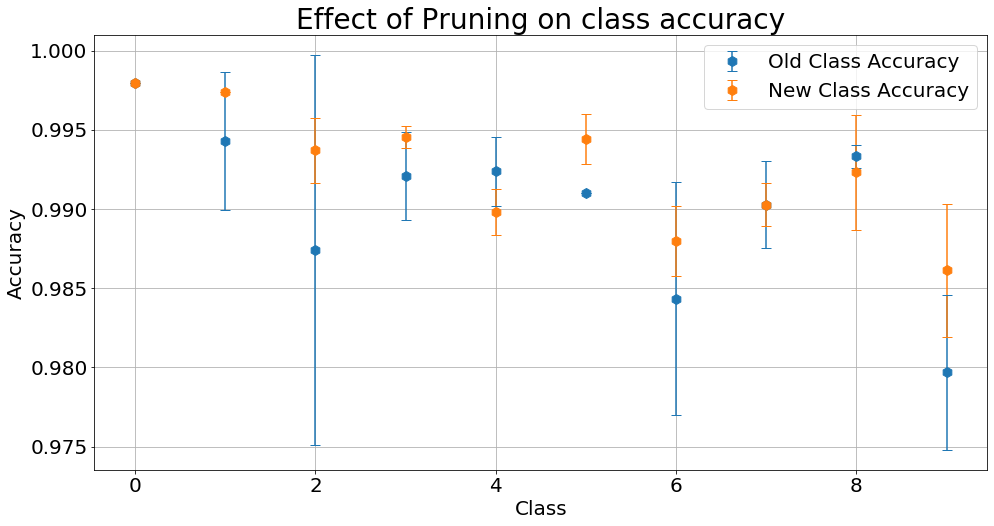

In [38]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = OCA.mean().to_numpy()
std_1 = OCA.std().to_numpy()
m_2 = NCA.mean().to_numpy()
std_2 = NCA.std().to_numpy()
plt.errorbar(x=np.arange(10), y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Old Class Accuracy', fmt='o')
plt.errorbar(x=np.arange(10), y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='New Class Accuracy', fmt='o')
plt.legend(fontsize=20)
plt.title("Effect of Pruning on class accuracy", size=28)
plt.xlabel("Class", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/acc_eff_CNN_class_mnist.png")

### Fashion MNIST

In [13]:
np.random.seed(2020)

In [14]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [16]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
trials = 10
tol = -1e-5
ig_cutoff = -1e-3
layer_sizes = [64, 256, 128, 64, 32]
old_class_accs = np.zeros((trials, 10))
new_class_accs = np.zeros((trials, 10))
diff_class_accs = np.zeros((trials, 10))
old_accs = np.zeros((trials))
new_accs = np.zeros((trials))
old_losses = np.zeros((trials))
new_losses = np.zeros((trials))
for trial in tqdm.trange(trials):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
        ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, verbose=0, epochs=5)
    old_losses[trial], old_accs[trial] = model.evaluate(x_test, y_test, verbose=0)
    
    y_pred = model.predict(x_test)
    K = 10
    acc1 = []
    yp = np.argmax(y_pred, axis=1)
    for i in range(K):
        a = np.mean((yp[y_test == i] == y_test[y_test == i]))
        acc1.append(a)
    old_class_accs[trial] = acc1
    
    
    shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cutoff, method='greedy')
    
    tester_model.set_weights(shrinked_weights)
    new_losses[trial], new_accs[trial] = tester_model.evaluate(x_test, y_test, verbose=0)
    
    y_pred = tester_model.predict(x_test)
    K = 10
    acc2 = []
    yp = np.argmax(y_pred, axis=1)
    for i in range(K):
        a = np.mean((yp[y_test == i] == y_test[y_test == i]))
        acc2.append(a)
    new_class_accs[trial] = acc2
    
    diff_class_accs[trial] = np.array(acc2) - np.array(acc1)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

[0.9979591836734694, 0.9973568281938326, 0.9786821705426356, 0.994059405940594, 0.9938900203665988, 0.9910313901345291, 0.9895615866388309, 0.9922178988326849, 0.9938398357289527, 0.9762140733399405]


 50%|█████████████████████████████████████████                                         | 1/2 [17:10<17:10, 1030.41s/it]

[0.9979591836734694, 0.9973568281938326, 0.9922480620155039, 0.995049504950495, 0.9908350305498982, 0.9955156950672646, 0.9895615866388309, 0.9912451361867705, 0.9897330595482546, 0.9890981169474727]
[0.9979591836734694, 0.9911894273127754, 0.9961240310077519, 0.9900990099009901, 0.9908350305498982, 0.9910313901345291, 0.9791231732776617, 0.9883268482490273, 0.9928131416837782, 0.9831516352824579]


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [32:26<00:00, 973.04s/it]

[0.9979591836734694, 0.9973568281938326, 0.9951550387596899, 0.994059405940594, 0.9887983706720977, 0.9932735426008968, 0.9864300626304802, 0.9892996108949417, 0.9948665297741273, 0.9831516352824579]


In [29]:
diff_class_accs

array([[ 0.        ,  0.        ,  0.01356589,  0.0009901 , -0.00305499,
         0.0044843 ,  0.        , -0.00097276, -0.00410678,  0.01288404],
       [ 0.        ,  0.0061674 , -0.00096899,  0.0039604 , -0.00203666,
         0.00224215,  0.00730689,  0.00097276,  0.00205339,  0.        ]])

In [30]:
DCA = pd.DataFrame(diff_class_accs)
DCA.to_csv('../../../results/diff_class_acc_CNN_class_fmnist.csv')
DCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,2.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.0,0.003084,0.006298,0.002475,-0.002546,0.003363,0.003653,0.000000,-0.001027,0.006442
std,0.0,0.004361,0.010278,0.002100,0.000720,0.001585,0.005167,0.001376,0.004356,0.009110
min,0.0,0.000000,-0.000969,0.000990,-0.003055,0.002242,0.000000,-0.000973,-0.004107,0.000000
25%,0.0,0.001542,0.002665,0.001733,-0.002800,0.002803,0.001827,-0.000486,-0.002567,0.003221
50%,0.0,0.003084,0.006298,0.002475,-0.002546,0.003363,0.003653,0.000000,-0.001027,0.006442
75%,0.0,0.004626,0.009932,0.003218,-0.002291,0.003924,0.005480,0.000486,0.000513,0.009663
max,0.0,0.006167,0.013566,0.003960,-0.002037,0.004484,0.007307,0.000973,0.002053,0.012884


In [31]:
OCA = pd.DataFrame(old_class_accs)
OCA.to_csv('../../../results/old_class_acc_CNN_class_fmnist.csv')
OCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.997959,0.994273,0.987403,0.992079,0.992363,0.991031,0.984342,0.990272,0.993326,0.979683
std,0.000000,0.004361,0.012333,0.002800,0.002160,0.000000,0.007381,0.002751,0.000726,0.004906
min,0.997959,0.991189,0.978682,0.990099,0.990835,0.991031,0.979123,0.988327,0.992813,0.976214
25%,0.997959,0.992731,0.983043,0.991089,0.991599,0.991031,0.981733,0.989300,0.993070,0.977948
50%,0.997959,0.994273,0.987403,0.992079,0.992363,0.991031,0.984342,0.990272,0.993326,0.979683
75%,0.997959,0.995815,0.991764,0.993069,0.993126,0.991031,0.986952,0.991245,0.993583,0.981417
max,0.997959,0.997357,0.996124,0.994059,0.993890,0.991031,0.989562,0.992218,0.993840,0.983152


In [32]:
NCA = pd.DataFrame(new_class_accs)
NCA.to_csv('../../../results/new_class_acc_CNN_class_fmnist.csv')
NCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.997959,0.997357,0.993702,0.994554,0.989817,0.994395,0.987996,0.990272,0.992300,0.986125
std,0.000000,0.000000,0.002056,0.000700,0.001440,0.001585,0.002214,0.001376,0.003630,0.004205
min,0.997959,0.997357,0.992248,0.994059,0.988798,0.993274,0.986430,0.989300,0.989733,0.983152
25%,0.997959,0.997357,0.992975,0.994307,0.989308,0.993834,0.987213,0.989786,0.991016,0.984638
50%,0.997959,0.997357,0.993702,0.994554,0.989817,0.994395,0.987996,0.990272,0.992300,0.986125
75%,0.997959,0.997357,0.994428,0.994802,0.990326,0.994955,0.988779,0.990759,0.993583,0.987611
max,0.997959,0.997357,0.995155,0.995050,0.990835,0.995516,0.989562,0.991245,0.994867,0.989098


In [33]:
A = pd.DataFrame(np.array([old_accs, new_accs]).T, columns=['Before Pruning', 'After Pruning'])
A.to_csv('../../../results/acc_CNN_class_fmnist.csv')
A.describe()

,Before Pruning,After Pruning
count,2.000000,2.000000
mean,0.990300,0.992500
std,0.000283,0.000566
min,0.990100,0.992100
25%,0.990200,0.992300
50%,0.990300,0.992500
75%,0.990400,0.992700
max,0.990500,0.992900


In [34]:
L = pd.DataFrame(np.array([old_losses, new_losses]).T, columns=['Before Pruning', 'After Pruning'])
L.to_csv('../../../results/loss_CNN_class_fmnist.csv')
L.describe()

,Before Pruning,After Pruning
count,2.000000,2.000000
mean,0.032786,0.028177
std,0.003140,0.000495
min,0.030566,0.027827
25%,0.031676,0.028002
50%,0.032786,0.028177
75%,0.033896,0.028352
max,0.035006,0.028527


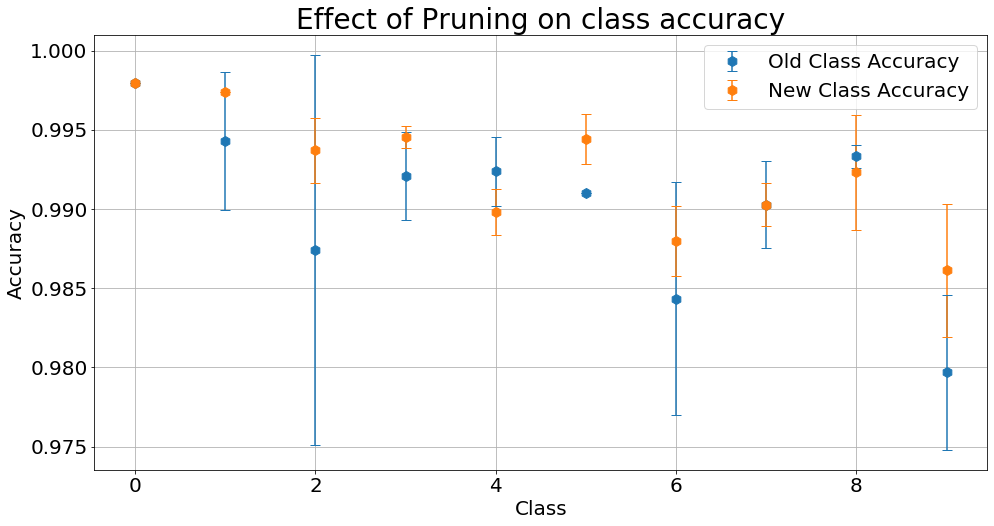

In [38]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = OCA.mean().to_numpy()
std_1 = OCA.std().to_numpy()
m_2 = NCA.mean().to_numpy()
std_2 = NCA.std().to_numpy()
plt.errorbar(x=np.arange(10), y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Old Class Accuracy', fmt='o')
plt.errorbar(x=np.arange(10), y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='New Class Accuracy', fmt='o')
plt.legend(fontsize=20)
plt.title("Effect of Pruning on class accuracy", size=28)
plt.xlabel("Class", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/acc_eff_CNN_class_fmnist.png")

### CIFAR 10

In [79]:
np.random.seed(2020)

In [80]:
cifar = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [81]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
trials = 10
tol = -1e-5
ig_cutoff = -1e-3
layer_sizes = [64, 256, 128, 64, 32]
old_class_accs = np.zeros((trials, 10))
new_class_accs = np.zeros((trials, 10))
diff_class_accs = np.zeros((trials, 10))
old_accs = np.zeros((trials))
new_accs = np.zeros((trials))
old_losses = np.zeros((trials))
new_losses = np.zeros((trials))
for trial in tqdm.trange(trials):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
        ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, verbose=0, epochs=5)
    old_losses[trial], old_accs[trial] = model.evaluate(x_test, y_test, verbose=0)
    
    y_pred = model.predict(x_test)
    K = 10
    acc1 = []
    yp = np.argmax(y_pred, axis=1)
    for i in range(K):
        a = np.mean((yp[y_test == i] == y_test[y_test == i]))
        acc1.append(a)
    old_class_accs[trial] = acc1
    
    
    shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cutoff, method='greedy')
    
    tester_model.set_weights(shrinked_weights)
    new_losses[trial], new_accs[trial] = tester_model.evaluate(x_test, y_test, verbose=0)
    
    y_pred = tester_model.predict(x_test)
    K = 10
    acc2 = []
    yp = np.argmax(y_pred, axis=1)
    for i in range(K):
        a = np.mean((yp[y_test == i] == y_test[y_test == i]))
        acc2.append(a)
    new_class_accs[trial] = acc2
    
    diff_class_accs[trial] = np.array(acc2) - np.array(acc1)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

[0.9979591836734694, 0.9973568281938326, 0.9786821705426356, 0.994059405940594, 0.9938900203665988, 0.9910313901345291, 0.9895615866388309, 0.9922178988326849, 0.9938398357289527, 0.9762140733399405]


 50%|█████████████████████████████████████████                                         | 1/2 [17:10<17:10, 1030.41s/it]

[0.9979591836734694, 0.9973568281938326, 0.9922480620155039, 0.995049504950495, 0.9908350305498982, 0.9955156950672646, 0.9895615866388309, 0.9912451361867705, 0.9897330595482546, 0.9890981169474727]
[0.9979591836734694, 0.9911894273127754, 0.9961240310077519, 0.9900990099009901, 0.9908350305498982, 0.9910313901345291, 0.9791231732776617, 0.9883268482490273, 0.9928131416837782, 0.9831516352824579]


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [32:26<00:00, 973.04s/it]

[0.9979591836734694, 0.9973568281938326, 0.9951550387596899, 0.994059405940594, 0.9887983706720977, 0.9932735426008968, 0.9864300626304802, 0.9892996108949417, 0.9948665297741273, 0.9831516352824579]


In [29]:
diff_class_accs

array([[ 0.        ,  0.        ,  0.01356589,  0.0009901 , -0.00305499,
         0.0044843 ,  0.        , -0.00097276, -0.00410678,  0.01288404],
       [ 0.        ,  0.0061674 , -0.00096899,  0.0039604 , -0.00203666,
         0.00224215,  0.00730689,  0.00097276,  0.00205339,  0.        ]])

In [30]:
DCA = pd.DataFrame(diff_class_accs)
DCA.to_csv('../../../results/diff_class_acc_CNN_class_cifar.csv')
DCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,2.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.0,0.003084,0.006298,0.002475,-0.002546,0.003363,0.003653,0.000000,-0.001027,0.006442
std,0.0,0.004361,0.010278,0.002100,0.000720,0.001585,0.005167,0.001376,0.004356,0.009110
min,0.0,0.000000,-0.000969,0.000990,-0.003055,0.002242,0.000000,-0.000973,-0.004107,0.000000
25%,0.0,0.001542,0.002665,0.001733,-0.002800,0.002803,0.001827,-0.000486,-0.002567,0.003221
50%,0.0,0.003084,0.006298,0.002475,-0.002546,0.003363,0.003653,0.000000,-0.001027,0.006442
75%,0.0,0.004626,0.009932,0.003218,-0.002291,0.003924,0.005480,0.000486,0.000513,0.009663
max,0.0,0.006167,0.013566,0.003960,-0.002037,0.004484,0.007307,0.000973,0.002053,0.012884


In [31]:
OCA = pd.DataFrame(old_class_accs)
OCA.to_csv('../../../results/old_class_acc_CNN_class_cifar.csv')
OCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.997959,0.994273,0.987403,0.992079,0.992363,0.991031,0.984342,0.990272,0.993326,0.979683
std,0.000000,0.004361,0.012333,0.002800,0.002160,0.000000,0.007381,0.002751,0.000726,0.004906
min,0.997959,0.991189,0.978682,0.990099,0.990835,0.991031,0.979123,0.988327,0.992813,0.976214
25%,0.997959,0.992731,0.983043,0.991089,0.991599,0.991031,0.981733,0.989300,0.993070,0.977948
50%,0.997959,0.994273,0.987403,0.992079,0.992363,0.991031,0.984342,0.990272,0.993326,0.979683
75%,0.997959,0.995815,0.991764,0.993069,0.993126,0.991031,0.986952,0.991245,0.993583,0.981417
max,0.997959,0.997357,0.996124,0.994059,0.993890,0.991031,0.989562,0.992218,0.993840,0.983152


In [32]:
NCA = pd.DataFrame(new_class_accs)
NCA.to_csv('../../../results/new_class_acc_CNN_class_cifar.csv')
NCA.describe()

,0,1,2,3,4,5,6,7,8,9
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.997959,0.997357,0.993702,0.994554,0.989817,0.994395,0.987996,0.990272,0.992300,0.986125
std,0.000000,0.000000,0.002056,0.000700,0.001440,0.001585,0.002214,0.001376,0.003630,0.004205
min,0.997959,0.997357,0.992248,0.994059,0.988798,0.993274,0.986430,0.989300,0.989733,0.983152
25%,0.997959,0.997357,0.992975,0.994307,0.989308,0.993834,0.987213,0.989786,0.991016,0.984638
50%,0.997959,0.997357,0.993702,0.994554,0.989817,0.994395,0.987996,0.990272,0.992300,0.986125
75%,0.997959,0.997357,0.994428,0.994802,0.990326,0.994955,0.988779,0.990759,0.993583,0.987611
max,0.997959,0.997357,0.995155,0.995050,0.990835,0.995516,0.989562,0.991245,0.994867,0.989098


In [33]:
A = pd.DataFrame(np.array([old_accs, new_accs]).T, columns=['Before Pruning', 'After Pruning'])
A.to_csv('../../../results/acc_CNN_class_cifar.csv')
A.describe()

,Before Pruning,After Pruning
count,2.000000,2.000000
mean,0.990300,0.992500
std,0.000283,0.000566
min,0.990100,0.992100
25%,0.990200,0.992300
50%,0.990300,0.992500
75%,0.990400,0.992700
max,0.990500,0.992900


In [34]:
L = pd.DataFrame(np.array([old_losses, new_losses]).T, columns=['Before Pruning', 'After Pruning'])
L.to_csv('../../../results/loss_CNN_class_cifar.csv')
L.describe()

,Before Pruning,After Pruning
count,2.000000,2.000000
mean,0.032786,0.028177
std,0.003140,0.000495
min,0.030566,0.027827
25%,0.031676,0.028002
50%,0.032786,0.028177
75%,0.033896,0.028352
max,0.035006,0.028527


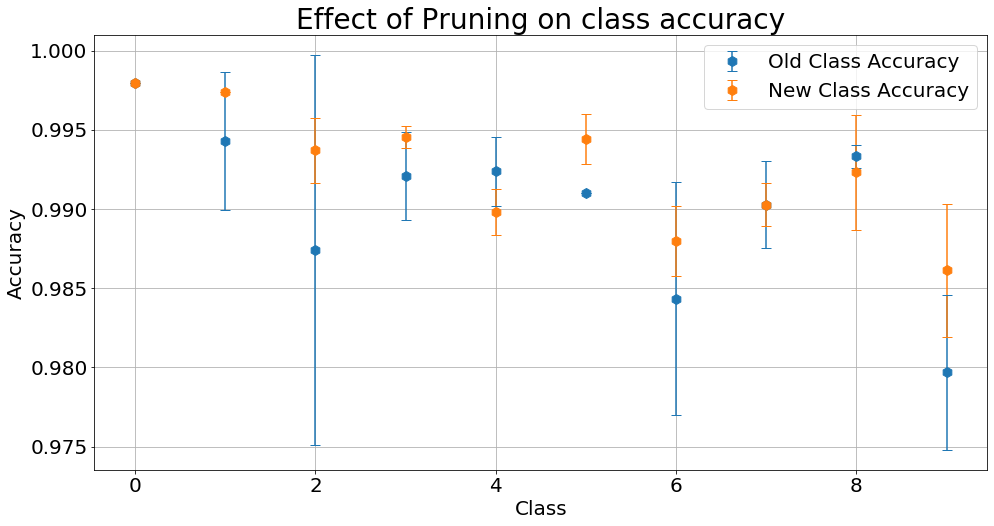

In [38]:
plt.rcParams["figure.figsize"] = (16,8)
idx = pd.IndexSlice
fig, ax = plt.subplots()
m_1 = OCA.mean().to_numpy()
std_1 = OCA.std().to_numpy()
m_2 = NCA.mean().to_numpy()
std_2 = NCA.std().to_numpy()
plt.errorbar(x=np.arange(10), y=m_1, yerr=std_1, capsize=5, marker='h', markersize=10, alpha=1, label='Old Class Accuracy', fmt='o')
plt.errorbar(x=np.arange(10), y=m_2, yerr=std_2, capsize=5, marker='h', markersize=10, alpha=1, label='New Class Accuracy', fmt='o')
plt.legend(fontsize=20)
plt.title("Effect of Pruning on class accuracy", size=28)
plt.xlabel("Class", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/acc_eff_CNN_class_cifar.png")